# Описание задачи

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!

Целью вашего проекта будет разработанная модель предсказания стоимости автомобиля на вторичном рынке.

# Метрика качества

Работа вашей модели будет оцениваться по метрике MAPE (Mean Absolute Percentage Error)

# Описание полей данных

- Date: Год выпуска автомобиля.
- Make: Марка автомобиля.
- Model: Модель автомобиля определенной марки.
- Trim: Модификации автомобиля.
- Body: Тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.
- Transmission: Тип коробки передач.
- VIN: Идентификационный номер транспортного средства.
- State: Штат регистрации автомобиля
- Condition: Состояние автомобилей на момент аукциона.
- Odometer: Пробег - расстояние, пройденное автомобилем с момента выпуска.
- Color: Цвет кузова автомобиля.
- Interior: Цвет салона автомобиля.
- Seller: Продавец автомобиля, автосалоны.
- sellingprice: цена, по которой автомобиль был продан на аукционе.
- saledate: Дата продажи автомобиля.

## Подготовка

In [1]:
import pandas as pd # библиотека Pandas
from sklearn.pipeline import Pipeline, FeatureUnion # pipe
from sklearn.preprocessing import StandardScaler # стандартизация
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import get_scorer_names
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_percentage_error
from dateutil.parser import parse
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor # модель бустинга
import scipy.stats as ss
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor # Линейная регрессия
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv, CatBoost
from sklearn.ensemble import StackingRegressor
from sklearn.svm import LinearSVR

from category_encoders.m_estimate import MEstimateEncoder
from sklearn.pipeline import make_pipeline

Заранее пропишем функцию для корреляции Крамера.

In [2]:
def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

Загрузим датасет и посмотрим корреляции категориальных признаков.

In [3]:
data = pd.read_csv('train.csv')
data.drop(columns=['vin'], inplace=True)
num_cols = data._get_numeric_data().columns
cat_cols = list(set(data.columns) - set(num_cols))
# for cat in cat_cols:
#     confusion_matrix = pd.crosstab(data[cat], data['sellingprice'])
#     print(cat, cramers_v(confusion_matrix.values))

Наибольшие корреляции с целевым признаком наблюдаются у марки автомобиля, модели, продавца.

Проверим уникальные значения полей.

In [4]:
data['make'].unique()

array(['Ford', 'Nissan', 'HUMMER', 'Lincoln', 'pontiac', 'Hyundai', nan,
       'Buick', 'Chevrolet', 'Honda', 'Acura', 'Cadillac', 'GMC', 'Saab',
       'Dodge', 'Mercedes-Benz', 'Toyota', 'Volkswagen', 'BMW',
       'Infiniti', 'Chrysler', 'Kia', 'Jaguar', 'Subaru', 'Jeep', 'Lexus',
       'mercedes', 'Scion', 'FIAT', 'Suzuki', 'Mazda', 'Volvo', 'Audi',
       'MINI', 'Isuzu', 'Mitsubishi', 'smart', 'Pontiac', 'Porsche',
       'subaru', 'ford', 'Land Rover', 'chrysler', 'Saturn', 'mazda',
       'dodge', 'Ram', 'Oldsmobile', 'hyundai', 'Mercury', 'Bentley',
       'toyota', 'lincoln', 'Fisker', 'nissan', 'chevrolet', 'honda',
       'porsche', 'mitsubishi', 'lexus', 'bmw', 'Maserati', 'acura',
       'jeep', 'mercury', 'Tesla', 'landrover', 'vw', 'cadillac', 'buick',
       'gmc truck', 'land rover', 'volkswagen', 'Rolls-Royce', 'audi',
       'Ferrari', 'suzuki', 'Plymouth', 'oldsmobile', 'Lamborghini',
       'gmc', 'Geo', 'ford truck', 'Aston Martin', 'plymouth', 'Daewoo',
      

Некоторые названия дублируются с различными регистрами и сокращениями, приведем все к нижнему регистру.

In [5]:
data['make'] = data['make'].str.lower()

In [6]:
print(sorted(data['make'].unique().astype(str)))

['acura', 'airstream', 'aston martin', 'audi', 'bentley', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'daewoo', 'dodge', 'dodge tk', 'dot', 'ferrari', 'fiat', 'fisker', 'ford', 'ford truck', 'geo', 'gmc', 'gmc truck', 'honda', 'hummer', 'hyundai', 'infiniti', 'isuzu', 'jaguar', 'jeep', 'kia', 'lamborghini', 'land rover', 'landrover', 'lexus', 'lincoln', 'maserati', 'mazda', 'mazda tk', 'mercedes', 'mercedes-b', 'mercedes-benz', 'mercury', 'mini', 'mitsubishi', 'nan', 'nissan', 'oldsmobile', 'plymouth', 'pontiac', 'porsche', 'ram', 'rolls-royce', 'saab', 'saturn', 'scion', 'smart', 'subaru', 'suzuki', 'tesla', 'toyota', 'volkswagen', 'volvo', 'vw']


Создадим словарь, по которому будем приводить названия к одному виду.

In [7]:
auto_dict = {'land rover': 'landrover', 'mercedes-b' : 'mercedes', 'mercedes-benz': 'mercedes', 'vw' : 'volkswagen'}

In [8]:
data['make'] = data['make'].apply(lambda x: auto_dict.get(x) if x in auto_dict else x)

Построим графики зависимости цены от марки машины.

<Axes: xlabel='make'>

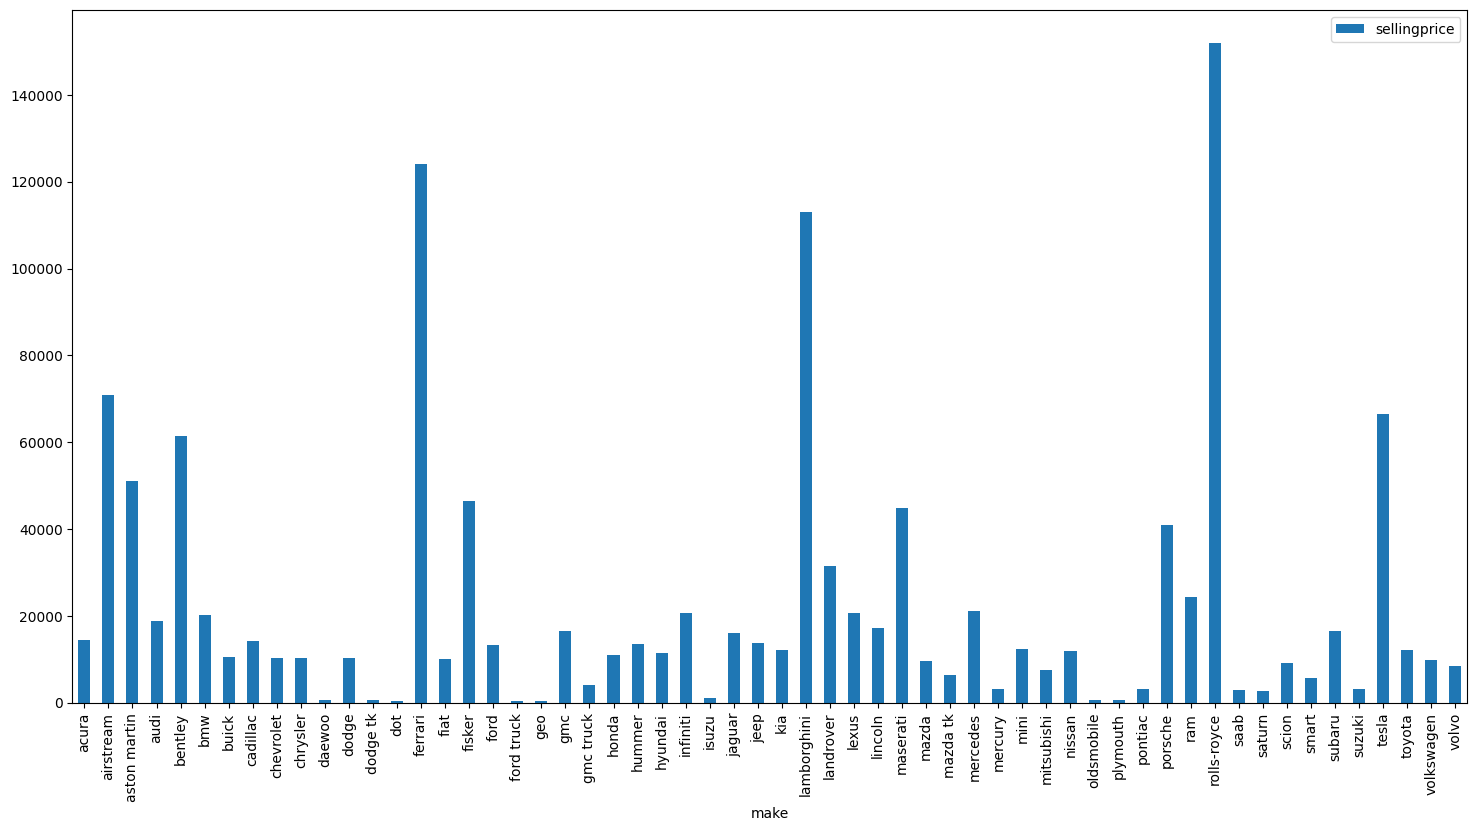

In [9]:
data.pivot_table(index='make', values='sellingprice', aggfunc='median').reset_index()\
.plot(x='make', y='sellingprice', kind='bar', figsize=(18, 9))

Можно легко заметить, что цены на автомобили в зависимости от марки существенно отличаются.

<Axes: xlabel='condition'>

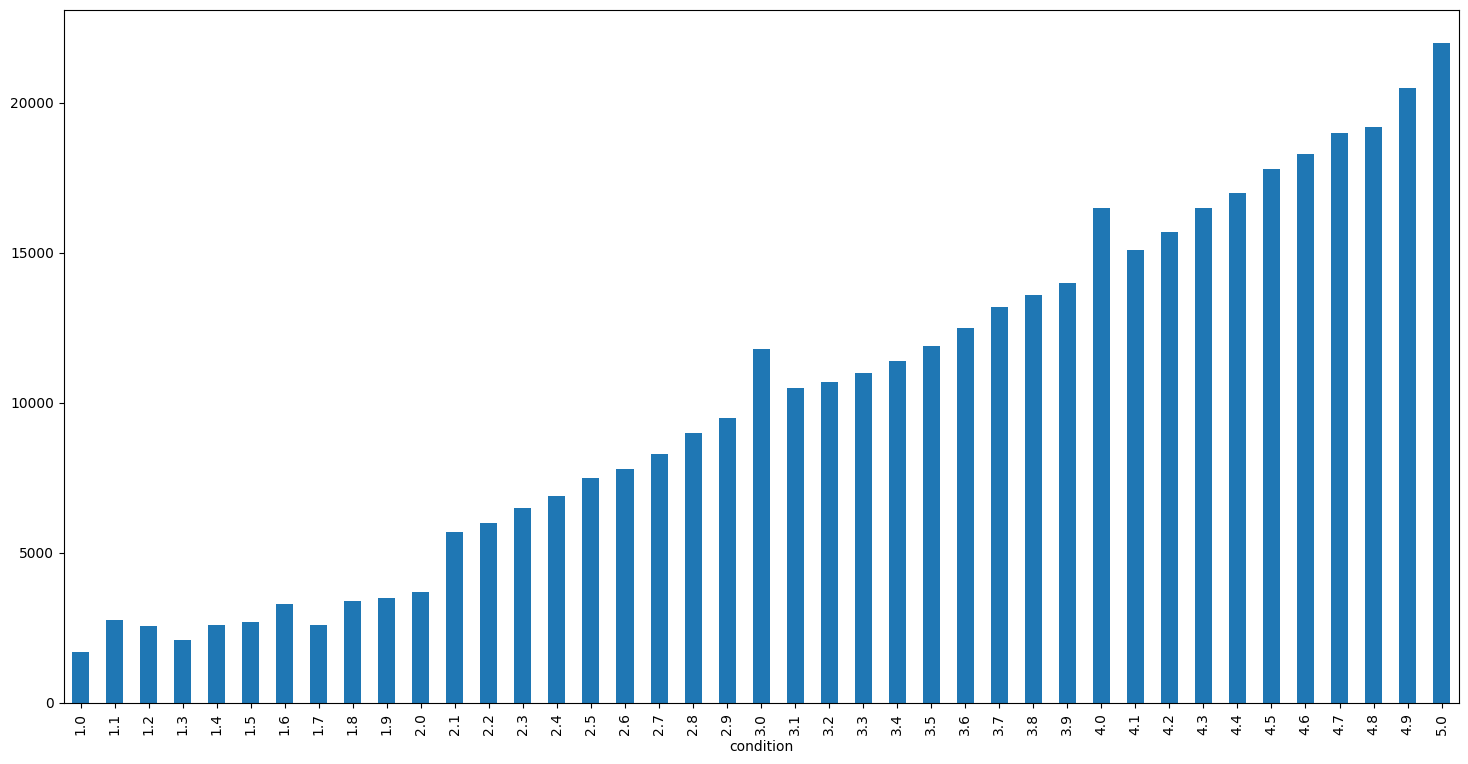

In [10]:
data.groupby('condition')['sellingprice'].median().plot(kind='bar', figsize=(18, 9))

Также в среднем по состоянию автомобиля цена растет.

Оценим разброс значений.

In [11]:
data.describe()

,year,condition,odometer,sellingprice
count,440236.000000,430831.000000,440167.000000,440236.000000
mean,2010.040101,3.425077,68344.421604,13592.209588
std,3.977945,0.949973,53542.203908,9751.479098
min,1982.000000,1.000000,1.000000,1.000000
25%,2007.000000,2.700000,28258.000000,6900.000000
50%,2012.000000,3.600000,52098.000000,12100.000000
75%,2013.000000,4.200000,99272.000000,18200.000000
max,2015.000000,5.000000,999999.000000,230000.000000


Можно заметить, что у некоторых автомобилей почти отсутстует пробег, проверим эти данные.

In [12]:
data.query('odometer == 1')

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,saledate
125,2000,jeep,Cherokee,Sport,SUV,automatic,ny,3.1,1.0,blue,gray,morehead auto sales inc,300,Wed Jan 21 2015 01:00:00 GMT-0800 (PST)
212,2007,gmc,Yukon,SLE,SUV,automatic,tx,2.1,1.0,black,black,shamaley buick gmc,10000,Thu Jan 22 2015 04:00:00 GMT-0800 (PST)
270,2000,nissan,Altima,GXE,Sedan,automatic,nv,2.0,1.0,black,—,titlemax of eastern ave. - nv 7,800,Thu Mar 05 2015 03:00:00 GMT-0800 (PST)
788,2013,hyundai,Accent,GLS,Sedan,automatic,az,1.0,1.0,red,gray,enterprise vehicle exchange / tra / rental / t...,4700,Wed Jan 07 2015 11:00:00 GMT-0800 (PST)
993,1997,toyota,Camry,XLE,Sedan,automatic,ga,2.0,1.0,beige,tan,capital auto auction,1000,Thu Feb 19 2015 04:30:00 GMT-0800 (PST)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438289,2002,acura,RL,3.5,Sedan,automatic,mo,1.9,1.0,black,tan,hendrick lexus kansas city,1400,Wed Dec 31 2014 10:30:00 GMT-0800 (PST)
439216,1999,oldsmobile,intrigue,base,NaN,automatic,sc,NaN,1.0,green,beige,thomas auto sales inc,500,Thu Dec 18 2014 10:15:00 GMT-0800 (PST)
439366,2002,toyota,Camry,SE,Sedan,NaN,il,NaN,1.0,gray,—,grossinger city toyota,2850,Thu Dec 18 2014 13:00:00 GMT-0800 (PST)
439525,2005,nissan,Quest,3.5 SE,Minivan,automatic,fl,2.4,1.0,red,—,mid atlantic finance/clearwater,4500,Thu Jun 18 2015 09:50:00 GMT-0700 (PDT)


Таких данных довольно много и состояние у автомобилей чаще всего плохое, так что следует поправить это значение.

Напишем функцию предобработки данных. Добавим год продажи в качестве признака, умножим на 100 тысяч значения с пробегом 1, также мы уберем выбросы, поставив ценовую вилку для каждой модели машины от 70 до 130 % от средней стоимости.

In [13]:
def preprocessing(data):
    data['saledate'] = pd.to_datetime(data['saledate'], infer_datetime_format=True, utc=True )
    data['saledate'] = data['saledate'].dt.tz_convert('UTC')
    data['saleyear'] = pd.DatetimeIndex(data['saledate']).year
    data.drop(columns='saledate', inplace=True)
    data['transmission'].fillna(data.groupby(['make', 'model', 'trim', 'body'])['transmission'].transform('first'), inplace=True) 
    data['odometer'] = data['odometer'].apply(lambda x: x * 100000 if x==1 else x)
    data['mean_model_sellingprice'] = data.groupby(
        ['make', 'model', 'trim', 'body', 'year', 'saleyear', 'color', 'interior', 'state'])['sellingprice'].transform('median')
    data = data.query('mean_model_sellingprice * 0.7 < sellingprice < mean_model_sellingprice * 1.3')
    data.drop(columns=['mean_model_sellingprice'], inplace=True)
    print(data.isna().sum())
    print(data.shape)
    return data

In [14]:
data = preprocessing(data)

C:\Users\New\AppData\Local\Temp\ipykernel_3252\1373986185.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['saledate'] = pd.to_datetime(data['saledate'], infer_datetime_format=True, utc=True )
C:\Users\New\AppData\Local\Temp\ipykernel_3252\1373986185.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['saledate'] = pd.to_datetime(data['saledate'], infer_datetime_format=True, utc=True )


year               0
make               0
model              0
trim               0
body               0
transmission     140
state              0
condition       8749
odometer          54
color              0
interior           0
seller             0
sellingprice       0
saleyear           0
dtype: int64
(419990, 14)


C:\Users\New\AppData\Local\Temp\ipykernel_3252\1373986185.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['mean_model_sellingprice'], inplace=True)


In [15]:
data

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,saleyear
0,2011,ford,Edge,SEL,suv,automatic,md,4.2,111041.0,black,black,santander consumer,12500,2015
1,2014,ford,Fusion,SE,Sedan,automatic,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015
2,2012,nissan,Sentra,2.0 SL,sedan,automatic,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015
3,2003,hummer,H2,Base,suv,automatic,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015
4,2007,ford,Fusion,SEL,Sedan,automatic,md,2.0,127709.0,black,black,purple heart,1300,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440231,2013,kia,Optima,EX Hybrid,Sedan,automatic,ca,4.5,20434.0,white,beige,"kia motors america, inc",16000,2015
440232,2014,mini,Cooper Countryman,S ALL4,Wagon,automatic,wi,2.9,14675.0,white,black,bmw mini financial services,24250,2015
440233,2008,bmw,6 Series,650i,Coupe,automatic,ca,3.7,102552.0,gray,black,studio city auto group,16750,2015
440234,2014,ram,2500,SLT,Crew Cab,automatic,tx,3.0,29367.0,white,gray,express car & truck rental,33000,2015


Создадим этапы pipeline, категориальные признаки кодируем OHE, стандартизируем числовые признаки.

In [16]:
num_pipeline = Pipeline(steps=[
    ('scale', StandardScaler())
])
cat_pipeline = Pipeline(steps=[
    ('OHE', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

In [17]:
num_cols = list(data._get_numeric_data().columns)
cat_cols = list(set(data.columns) - set(num_cols))
num_cols.remove('sellingprice')

In [18]:
cat_cols, num_cols

(['make',
  'trim',
  'color',
  'seller',
  'model',
  'interior',
  'body',
  'transmission',
  'state'],
 ['year', 'condition', 'odometer', 'saleyear'])

In [19]:
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)
    ],
    remainder='passthrough',
    n_jobs=-1)

Разделяем датасет на тренировочный и тестовый датасет.

In [20]:
features_train = data.drop(columns='sellingprice', axis=1)
target_train = data['sellingprice']
X_train, X_test, y_train, y_test = train_test_split(features_train, target_train, test_size=0.2, random_state=75)

Пишем функцию для optuna.

In [21]:
def objective_gbm(trial):
    params_gbm = {
        "objective": 'regression',
        "n_estimators": 1000,
        "verbosity": -1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    gbm_model = LGBMRegressor(**params_gbm)
    
    pipeline = Pipeline(steps=[
        ('col_trans', col_trans),
        ('model', gbm_model)
    ])
    
    mape = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='neg_mean_absolute_percentage_error').mean()
    
    return mape

Запускаем обучение.

In [28]:
study_gbm = optuna.create_study(direction="maximize", study_name="Train")
study_gbm.optimize(objective_gbm, n_trials=30)
print(study_gbm.best_trial)

[I 2023-09-20 18:03:58,166] A new study created in memory with name: Train
[I 2023-09-20 18:08:24,192] Trial 0 finished with value: -0.15496019803831887 and parameters: {'learning_rate': 0.026199472337129947, 'num_leaves': 653, 'subsample': 0.22345252182415237, 'colsample_bytree': 0.6110040898482486, 'min_data_in_leaf': 93, 'lambda_l1': 0.17397355439855489, 'lambda_l2': 0.004647736291761403, 'feature_fraction': 0.7723077536564795, 'bagging_fraction': 0.7355970426498897, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 0 with value: -0.15496019803831887.
[I 2023-09-20 18:09:36,652] Trial 1 finished with value: -0.16999689403225685 and parameters: {'learning_rate': 0.05637131722033917, 'num_leaves': 61, 'subsample': 0.5770017405536768, 'colsample_bytree': 0.1054986869817342, 'min_data_in_leaf': 83, 'lambda_l1': 3.8413378236325513, 'lambda_l2': 6.655510295748272e-08, 'feature_fraction': 0.6857182785349418, 'bagging_fraction': 0.8033862680625521, 'bagging_freq': 2, 'min_child_sam

FrozenTrial(number=29, state=TrialState.COMPLETE, values=[-0.1316353126847941], datetime_start=datetime.datetime(2023, 9, 20, 19, 54, 46, 311320), datetime_complete=datetime.datetime(2023, 9, 20, 19, 59, 55, 213994), params={'learning_rate': 0.027718780132376403, 'num_leaves': 646, 'subsample': 0.7598030239811668, 'colsample_bytree': 0.4475187204041685, 'min_data_in_leaf': 8, 'lambda_l1': 1.4474966909426492e-08, 'lambda_l2': 6.394391805253028e-07, 'feature_fraction': 0.6296168471776615, 'bagging_fraction': 0.9300288287649648, 'bagging_freq': 5, 'min_child_samples': 100}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'num_leaves': IntDistribution(high=1024, log=False, low=2, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.05, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.05, step=None), 'min_data_in_leaf': IntDistribution(high=100, log=

In [29]:
gbm_options = study_gbm.best_params

Вытаскиваем параметры лучшей модели.

In [30]:
best_gbm_options = {"objective": 'regression',
                    "n_estimators": 1000,
                    "verbosity": -1} | gbm_options

In [31]:
gbm_best_model = LGBMRegressor(**best_gbm_options)
pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', gbm_best_model)
    ])


pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['year', 'condition',
                                                   'odometer', 'saleyear']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('OHE',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['make', 'trim', 'color',
                                                   'seller', 'model',
                                                   'interior', 'body...
                 LGBMRegressor(bagging_fraction=0.9300288287649648,
                               bagging_freq=5,
                               colsample_bytree=0.4475187204041685,
                               feature_fraction=0.6296168471776615,
                               lambda_l1=1.4474966909426492e-08,
                               lambda_l2=6.394391805253028e-07,
                               learning_rate=0.027718780132376403,
                               min_child_samples=100, min_data_in_leaf=8,
                               n_estimators=1000, num_leaves=646,
                               objective='regression',
                               subsample=0.7598030239811668, verbosity=-1))])

Делаем предсказание на тестовой выборке.

In [32]:
print(mean_absolute_percentage_error(y_test, pipeline.predict(X_test)))

0.20685162490684642
